# Projekt IUM 2020Z - zadanie 3
___
### Etap 1, iteracja 1


### Autorzy projektu
* Mateusz Marciniewicz
* Przemysław Bedełek

### Opis zadania


<i>Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Lepiej by było, gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia może potrwać.</i>




# Tło biznesowe
___

### Kontekst
Usprawnienie systemu dostaw w sklepie "eSzopping".

### Zadanie biznesowe
Stworzyć narzędzie do estymacji czasu dostawy towaru na podstawie danych o zakupach i sposobach przesyłki.

### Kryterium biznesowe
Nowy system ma za zadanie przewidywać czas dostawy poprawnie w przypadku 95% zamówień.



# Zadanie modelowania
____
### Typ zadania: Aproksymacja/Regresja

### Dane
Tabele dotyczące działalności sklepu zawierają poniższe informacje:
* baza użytkowników
* katalog produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

### Analityczne kryterium sukcesu:

<img src="https://latex.codecogs.com/gif.latex?\frac{y_{true}}{y_{true}&plus;y_{false}}\geq&space;95%" title="\frac{y_{true}}{y_{true}+y_{false}}\geq 95%" />

gdzie y<sub>true</sub> to liczba predykcji, które:

<img src="https://latex.codecogs.com/gif.latex?|y_{pred}-y|&space;<&space;4" title="|y_{pred}-y| < 4" />

Czas dostawy jest wyrażany w godzinach.



# Przegląd danych



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ium_preprocessed2.csv',index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4164 entries, 1 to 4164
Data columns (total 14 columns):
city                      4164 non-null object
street                    4164 non-null object
streetNumber              4164 non-null int64
delivery_company          4164 non-null object
purchase_month            4164 non-null object
purchase_day              4164 non-null int64
purchase_hour             4164 non-null int64
purchase_weekday          4164 non-null object
delivery_month            4164 non-null object
delivery_day              4164 non-null int64
delivery_hour             4164 non-null int64
delivery_weekday          4164 non-null object
shipping_time_in_hours    4164 non-null int64
category                  3942 non-null object
dtypes: int64(6), object(8)
memory usage: 488.0+ KB


In [4]:
# Rozdzielenie danych wejściowych od wyjściowych
y = df['shipping_time_in_hours']

Wszystkie kolumny z atrybutami treningowymi zawierają dane dzielące się na kategorie,
więc zostaje zmieniony ich dtype na 'categorical'.

In [5]:
x = df.drop(['shipping_time_in_hours'],axis=1)
x = x.astype('category')

W kolumnie category występują NaNy. Zostaną zamienione na 'Brak kategorii'.

In [6]:
x['category']=x['category'].cat.add_categories('Brak kategorii')
x['category']=x['category'].fillna('Brak kategorii')

In [7]:
x.head()

,city,street,streetNumber,delivery_company,purchase_month,purchase_day,purchase_hour,purchase_weekday,delivery_month,delivery_day,delivery_hour,delivery_weekday,category
Obs,,,,,,,,,,,,,
1,Warszawa,al. Mokra,49,C516,IX,6,9,Saturday,IX,7,22,Sunday,Brak kategorii
2,Gdynia,ul. Okrzei,90,C620,IV,28,12,Monday,V,1,6,Thursday,Brak kategorii
3,Police,pl. Dlugosza,70,C360,I,22,9,Tuesday,I,23,19,Wednesday,Brak kategorii
4,Gdynia,ul. Okrzei,90,C620,III,28,23,Friday,III,31,17,Monday,Brak kategorii
5,Radom,pl. Konstytucji 3 Maja,129,C360,VI,3,1,Tuesday,VI,4,0,Wednesday,Brak kategorii


In [8]:
x.describe()

,city,street,streetNumber,delivery_company,purchase_month,purchase_day,purchase_hour,purchase_weekday,delivery_month,delivery_day,delivery_hour,delivery_weekday,category
count,4164,4164,4164,4164,4164,4164,4164,4164,4164,4164,4164,4164,4164
unique,8,182,131,3,10,31,24,7,10,31,24,7,16
top,Konin,ul. Storczykowa,49,C620,I,25,23,Wednesday,VII,27,13,Sunday,Biurowe urzadzenia wielofunkcyjne
freq,584,69,121,1421,448,172,201,641,450,168,203,647,280


In [9]:
y.head()

Obs
1    37
2    66
3    34
4    66
5    24
Name: shipping_time_in_hours, dtype: int64

In [10]:
y.describe()

count    4164.000000
mean       48.651537
std        33.898612
min         1.000000
25%        22.000000
50%        43.000000
75%        69.000000
max       206.000000
Name: shipping_time_in_hours, dtype: float64

### Liczba rejestrowanych miesięcy

Spójrzmy na dane z kolumn purchase_month i delivery_month. Istnieje tylko 10 kategorii, a miesięcy jest 12 w roku.

In [11]:
print(x['purchase_month'].cat.categories)
print(x['delivery_month'].cat.categories)

Index(['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X'], dtype='object')
Index(['I', 'II', 'III', 'IV', 'IX', 'V', 'VI', 'VII', 'VIII', 'X'], dtype='object')


Dane najwyraźniej pochodzą z okresu 10 miesięcy.

### Korelacja między ulicami i miastami

Czas też sprawdzić jak są ze sobą 'skorelowane' ulice z miastami.
Jako iż zmienne w obu kolumnach mają charakter nominalny, policzymy
współczynnik V Cramera.

In [12]:
# def correlation_ratio(categories, measurements):
#     fcat, _ = pd.factorize(categories)
#     cat_num = np.max(fcat)+1
#     y_avg_array = np.zeros(cat_num)
#     n_array = np.zeros(cat_num)
#     for i in range(0,cat_num):
#         cat_measures = measurements[np.argwhere(fcat == i).flatten()]
#         n_array[i] = len(cat_measures)
#         y_avg_array[i] = np.average(cat_measures)
#     y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
#     numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
#     denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
#     if numerator == 0:
#         eta = 0.0
#     else:
#         eta = np.sqrt(numerator/denominator)
#     return eta
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [13]:
cramers_v(x['city'],x['street'])

0.9442778081859465

Obie kolumny są mocno ze sobą 'skorelowane', więc w danych ze zbioru treningowego kolumny street i street_number wprowadzają jedynie zbędne informacje. Wysoka korelacja przemawia za wyrzuceniem tych kolumn, ale w przyszłości mogą pojawić się dane z takimi samymi nazwami ulic w różnych miastach. 

### Dni i godziny dostawy

Porównanie działalności firm dostawczych.

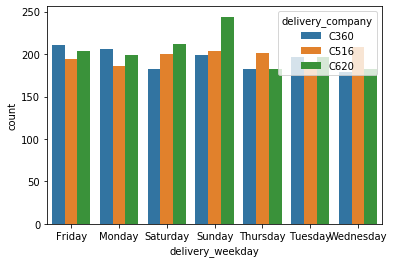

In [14]:
sns.countplot(data=x,x='delivery_weekday',hue='delivery_company')

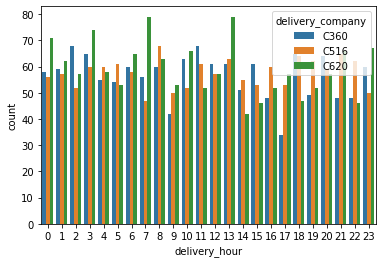

In [15]:
sns.countplot(data=x,x='delivery_hour',hue='delivery_company')

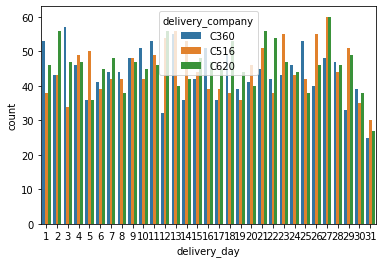

In [16]:
sns.countplot(data=x,x='delivery_day',hue='delivery_company')

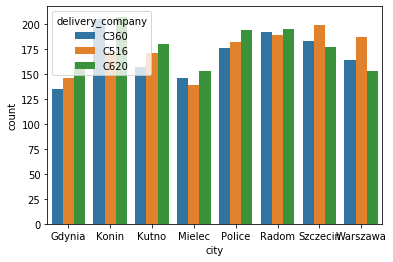

In [17]:
sns.countplot(data=x,x='city',hue='delivery_company')

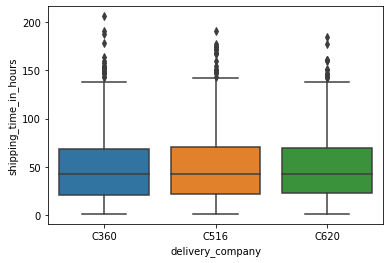

In [18]:
concat = x.copy()
concat['shipping_time_in_hours'] = y
sns.boxplot(data=concat,x='delivery_company',y='shipping_time_in_hours')

Jak widać firmy dostawcze dostawcze prowadzą bardzo podobną działalność.
Zastanawiająca jest ich praca w soboty i niedziele, jak i całodobowa dostępność kurierów. Wskazuje to na niereprezentatywność danych. 

# Wnioski
1. Po preprocessingu z 7000 + rekordów zostało nam jedynie 4164 rekordy. Taka liczba nie gwarantuje dobrego wytrenowania modelu. Wskazane jest pozyskanie większej ilości danych.
2. Dane nie odzwierciedlają faktycznej pracy kurierów. Dane wskazują na dostarczanie przesyłek 24/7, a to jak wszyscy wiemy nie ma miejsca w Polsce, ani chyba nigdzie indziej na świecie.
3. Jeśli istnieje interpretacja dla ujemnych czasów dostawy, można byłoby zyskać ponad 2000 rekordów. Do ustalenia z klientem.
4. Powstaje pytanie z jakiego okresu pochodzą te dane.
5. Proces dostarczenia przesyłki jest nieznany. Byćmoże istnieją centra logistyczne pośredniczące w przesyłce, które mają znaczny wpływ na czas przesyłki.